In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import grid2op
from grid2op.Agent import BaseAgent
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

C:\Users\makha\AppData\Roaming\Python\Python311\site-packages\grid2op\Backend\pandaPowerBackend.py:36: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Program Files\Python311\python.exe -m pip install numba

  warnings.warn(


In [2]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(int(state_size), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, int(action_size))
        )
    
    def forward(self, state):
        return self.network(state)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([exp.state for exp in experiences])
        actions = torch.LongTensor([exp.action for exp in experiences])
        rewards = torch.FloatTensor([exp.reward for exp in experiences])
        next_states = torch.FloatTensor([exp.next_state for exp in experiences])
        dones = torch.FloatTensor([exp.done for exp in experiences])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent(BaseAgent):
    def __init__(self, env, memory_size=100000, batch_size=64, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.999,
                 learning_rate=1e-4, target_update_frequency=500):
        super(DQNAgent, self).__init__(env.action_space)
        
        self.env = env
        
        obs = env.reset()
        self.state_size = len(obs.to_vect())
        
        self.action_space = env.action_space
        
        self.all_actions = [env.action_space({})]  # Do nothing action
        
        for line_id in range(env.action_space.n_line):
            self.all_actions.append(env.action_space.disconnect_powerline(line_id=line_id))
            
            for bus_or in [1, 2]:
                for bus_ex in [1, 2]:
                    try:
                        reconnect_action = env.action_space.reconnect_powerline(
                            line_id=line_id,
                            bus_or=bus_or,
                            bus_ex=bus_ex
                        )
                        self.all_actions.append(reconnect_action)
                    except grid2op.Exceptions.Grid2OpException:
                        continue
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_frequency = target_update_frequency
        
        self.policy_net = DQN(self.state_size, len(self.all_actions))
        self.target_net = DQN(self.state_size, len(self.all_actions))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.memory = ReplayBuffer(memory_size)
        self.writer = SummaryWriter('runs/dqn_training')
        self.total_steps = 0
        
        print(f"State size: {self.state_size}")
        print(f"Number of actions: {len(self.all_actions)}")
    
    def act(self, observation, reward=0.0, done=False):
        state = self.convert_obs(observation)
        
        if random.random() < self.epsilon:
            action_idx = random.randrange(len(self.all_actions))
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                action_idx = q_values.argmax().item()
        
        return self.all_actions[action_idx]
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.writer.add_scalar('Loss/train', loss.item(), self.total_steps)
        
        if self.total_steps % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def convert_obs(self, observation):
        return observation.to_vect()
    
    def convert_action(self, action):
        for idx, a in enumerate(self.all_actions):
            if a == action:
                return idx
        return 0  
    
    def save(self, path):
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']


In [3]:
def analyze_training_rewards(env_name="l2rpn_case14_sandbox", n_episodes=1000, max_steps=1000, window_size=100):
    all_rewards = []
    episode_lengths = []
    moving_averages = []
    episode_lengths_average = []
    best_reward = float('-inf')
    worst_reward = float('inf')
    reward_window = deque(maxlen=window_size)
    
    env = grid2op.make(env_name)
    agent = DQNAgent(env)
    
    print("Starting training...\n")
    
    for episode in range(n_episodes):
        observation = env.reset()
        episode_reward = 0
        steps = 0
        
        for step in range(max_steps):
            try:
                action = agent.act(observation)
                next_observation, reward, done, info = env.step(action)
                
                state = agent.convert_obs(observation)
                next_state = agent.convert_obs(next_observation)
                action_idx = agent.convert_action(action)
                agent.memory.push(state, action_idx, reward, next_state, done)
                
                episode_reward += reward
                steps += 1
                
                observation = next_observation
                agent.total_steps += 1
                agent.learn()
                
                if done:
                    break
                    
            except Exception as e:
                print(f"Error during episode {episode + 1}, step {step + 1}: {e}")
                break
        
        all_rewards.append(episode_reward)
        episode_lengths.append(steps)
        reward_window.append(episode_reward)
        moving_averages.append(np.mean(list(reward_window)))
        episode_lengths_average.append(np.mean(list(episode_lengths)))
        best_reward = max(best_reward, episode_reward)
        worst_reward = min(worst_reward, episode_reward)
        
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(list(reward_window))
            print(f"Episode {episode + 1}/{n_episodes}")
            print(f"Recent Average Reward: {avg_reward:.2f}")
            print(f"Episode Reward: {episode_reward:.2f}")
            print(f"Steps: {steps}")
            print("-" * 50)
    
    print("\nTraining Summary:")
    print("-" * 50)
    print(f"Total Episodes: {n_episodes}")
    print(f"Best Reward: {best_reward:.2f}")
    print(f"Worst Reward: {worst_reward:.2f}")
    print(f"Average Reward: {np.mean(all_rewards):.2f}")
    print(f"Median Reward: {np.median(all_rewards):.2f}")
    print(f"Final {window_size}-Episode Average: {moving_averages[-1]:.2f}")
    print(f"Average Episode Length: {np.mean(episode_lengths):.2f} steps")
    print("-" * 50)
    
    return agent, {
        'rewards': all_rewards,
        'moving_averages': moving_averages,
        'episode_lengths': episode_lengths,
        'episode_lengths_average': episode_lengths_average,
        'best_reward': best_reward,
        'worst_reward': worst_reward
    }


In [4]:
if __name__ == "__main__":
    agent, metrics = analyze_training_rewards(n_episodes=500)

State size: 467
Number of actions: 101
Starting training...



C:\Users\makha\AppData\Local\Temp\ipykernel_31664\2153494230.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([exp.state for exp in experiences])


Episode 10/500
Recent Average Reward: 206.15
Episode Reward: 117.33
Steps: 11
--------------------------------------------------
Episode 20/500
Recent Average Reward: 325.22
Episode Reward: 520.36
Steps: 20
--------------------------------------------------
Episode 30/500
Recent Average Reward: 344.43
Episode Reward: 1446.90
Steps: 50
--------------------------------------------------
Episode 40/500
Recent Average Reward: 360.12
Episode Reward: 180.47
Steps: 6
--------------------------------------------------
Episode 50/500
Recent Average Reward: 369.93
Episode Reward: 187.22
Steps: 5
--------------------------------------------------
Episode 60/500
Recent Average Reward: 401.35
Episode Reward: 188.71
Steps: 8
--------------------------------------------------
Episode 70/500
Recent Average Reward: 421.00
Episode Reward: 257.11
Steps: 8
--------------------------------------------------
Episode 80/500
Recent Average Reward: 442.82
Episode Reward: 321.00
Steps: 6
-----------------------

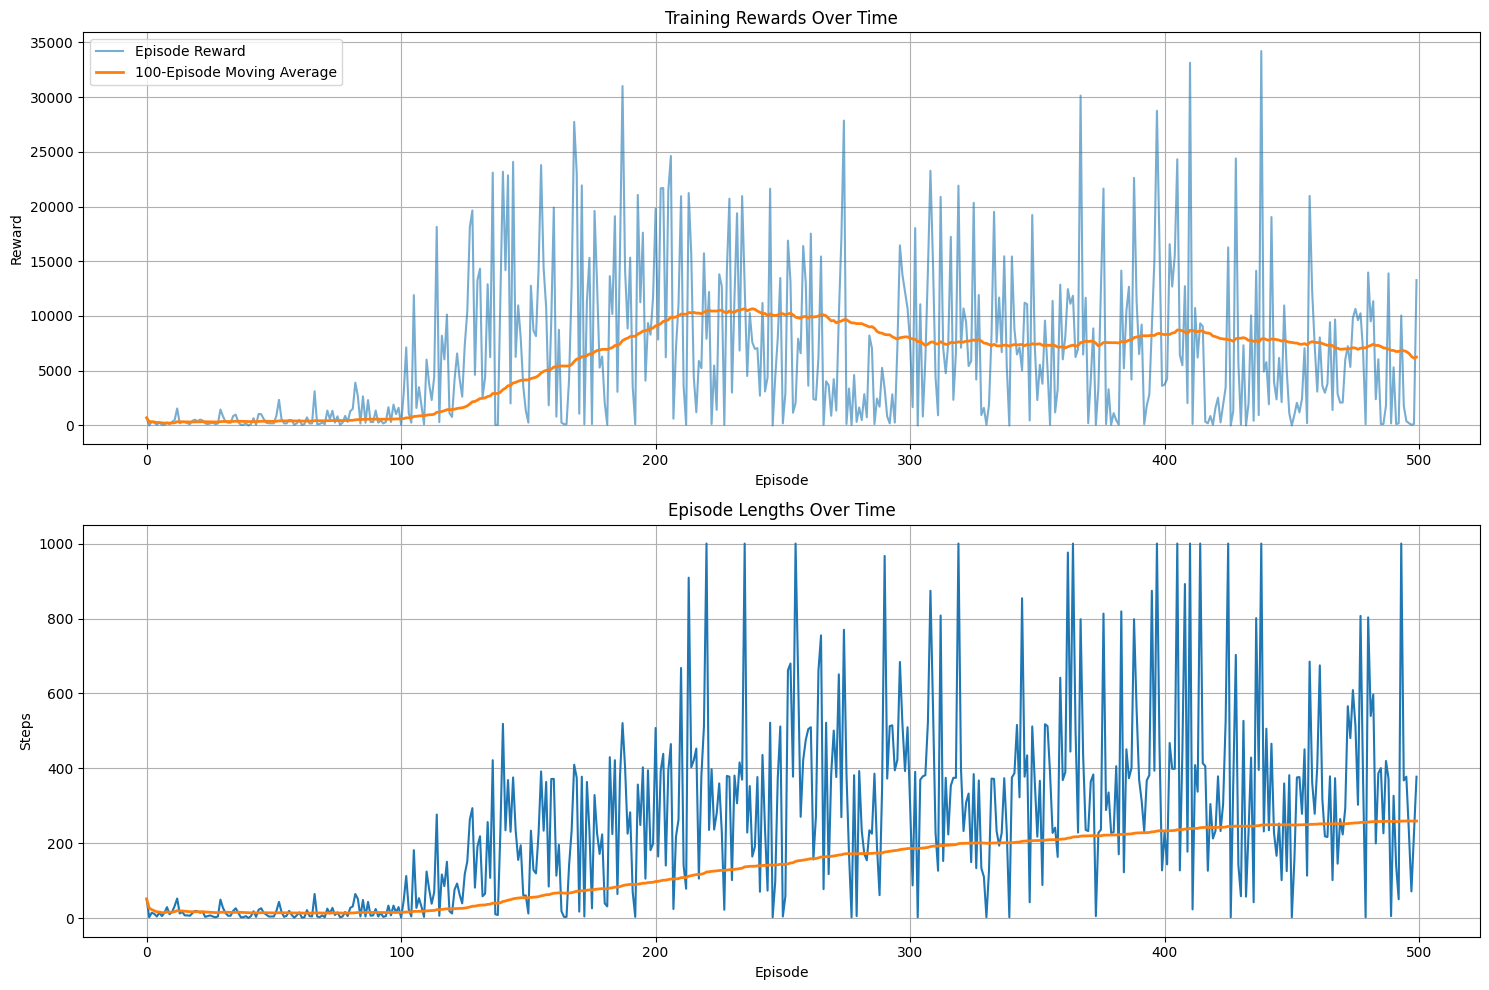

In [5]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(metrics['rewards'], label='Episode Reward', alpha=0.6)
plt.plot(metrics['moving_averages'], label=f'{100}-Episode Moving Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(metrics['episode_lengths'])
plt.plot(metrics['episode_lengths_average'], label=f'{100}-Episode Length Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Episode Lengths Over Time')
plt.grid(True)

plt.tight_layout()

In [6]:
agent.save("dqn_model_v1.pth")
plt.savefig('dqn_training_model_v1.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
#*********************************************************************************************
#DQN Improvement V2: DQN + Reward Shaping
#*********************************************************************************************

In [7]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(int(state_size), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, int(action_size))
        )
    
    def forward(self, state):
        return self.network(state)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([exp.state for exp in experiences])
        actions = torch.LongTensor([exp.action for exp in experiences])
        rewards = torch.FloatTensor([exp.reward for exp in experiences])
        next_states = torch.FloatTensor([exp.next_state for exp in experiences])
        dones = torch.FloatTensor([exp.done for exp in experiences])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent(BaseAgent):
    def __init__(self, env, memory_size=100000, batch_size=64, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.999,
                 learning_rate=1e-4, target_update_frequency=500):
        super(DQNAgent, self).__init__(env.action_space)
        
        self.env = env
        obs = env.reset()
        self.state_size = len(obs.to_vect())
        self.action_space = env.action_space
        self.all_actions = [env.action_space({})]  
        
        for line_id in range(env.action_space.n_line):
            self.all_actions.append(env.action_space.disconnect_powerline(line_id=line_id))
            
            for bus_or in [1, 2]:
                for bus_ex in [1, 2]:
                    try:
                        reconnect_action = env.action_space.reconnect_powerline(
                            line_id=line_id,
                            bus_or=bus_or,
                            bus_ex=bus_ex
                        )
                        self.all_actions.append(reconnect_action)
                    except grid2op.Exceptions.Grid2OpException:
                        continue
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_frequency = target_update_frequency
        
        self.policy_net = DQN(self.state_size, len(self.all_actions))
        self.target_net = DQN(self.state_size, len(self.all_actions))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.memory = ReplayBuffer(memory_size)
        
        self.writer = SummaryWriter('runs/dqn_training')
        self.total_steps = 0
        
        print(f"State size: {self.state_size}")
        print(f"Number of actions: {len(self.all_actions)}")
    
    def act(self, observation, reward=0.0, done=False):
        state = self.convert_obs(observation)
        
        if random.random() < self.epsilon:
            action_idx = random.randrange(len(self.all_actions))
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                action_idx = q_values.argmax().item()
        
        return self.all_actions[action_idx]
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            best_actions = self.policy_net(next_states).argmax(1)
            next_q_values = self.target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.writer.add_scalar('Loss/train', loss.item(), self.total_steps)
        if self.total_steps % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def convert_obs(self, observation):
        return observation.to_vect()
    
    def convert_action(self, action):
        for idx, a in enumerate(self.all_actions):
            if a == action:
                return idx
        return 0  
    
    def save(self, path):
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']


In [8]:
def analyze_training_rewards(env_name="l2rpn_case14_sandbox", n_episodes=1000, max_steps=1000, window_size=100):
    all_rewards_v2 = []
    episode_lengths_2 = []
    moving_averages_2 = []
    episode_lengths_average_2 = []
    best_reward_2 = float('-inf')
    worst_reward_2 = float('inf')
    reward_window_2 = deque(maxlen=window_size)
    
    from grid2op.Parameters import Parameters
    params = Parameters()
    
    params.NO_OVERFLOW_DISCONNECTION = True
    params.MAX_LINE_STATUS_CHANGED = 999999
    params.MAX_SUB_CHANGED = 999999
    params.NB_TIMESTEP_OVERFLOW_ALLOWED = 5
    params.NB_TIMESTEP_RECONNECTION = 12
    
    env = grid2op.make(env_name, param=params)
    
    class SafetyWrapper:
        def __init__(self, env):
            self.env = env
            self.observation_space = env.observation_space
            self.action_space = env.action_space
            self.current_step = 0
            self.last_safe_state = None
        
        def reset(self):
            self.current_step = 0
            obs = self.env.reset()
            self.last_safe_state = obs
            return obs
        
        def step(self, action):
            self.current_step += 1
            
            try:
                simulated_obs, simulated_reward, simulated_done, simulated_info = self.env.simulate(action)
                
                if simulated_done and self.current_step < 10:
                    action = self.env.action_space()
                    obs, reward, done, info = self.env.step(action)
                else:
                    obs, reward, done, info = self.env.step(action)
                
                reward += 1.0
                
                if done and self.current_step < 10:
                    reward -= 100.0
                
                if done and self.current_step >= 10:
                    reward += 50.0
                
                self.last_safe_state = obs
                return obs, reward, done, info
                
            except Exception as e:
                print(f"Action caused error: {e}. Using fallback action.")
                action = self.env.action_space()
                return self.env.step(action)
    
    env = SafetyWrapper(env)
    agent_2 = DQNAgent(env)
    agent_2.epsilon = 1.0
    agent_2.epsilon_decay = 0.995
    agent_2.epsilon_min = 0.05
    
    print(f"State size: {env.observation_space.size()}")
    print(f"Number of actions: {env.action_space.n}")
    print("Starting training...\n")
    
    for episode in range(n_episodes):
        observation = env.reset()
        episode_reward = 0
        steps = 0
        
        for step in range(max_steps):
            try:
                action = agent_2.act(observation)
                next_observation, reward, done, info = env.step(action)
                
                state = agent_2.convert_obs(observation)
                next_state = agent_2.convert_obs(next_observation)
                action_idx = agent_2.convert_action(action)
                agent_2.memory.push(state, action_idx, reward, next_state, done)
                
                episode_reward += reward
                steps += 1
                
                observation = next_observation
                agent_2.total_steps += 1
                agent_2.learn()
                
                if done:
                    break
                    
            except Exception as e:
                print(f"Error during episode {episode + 1}, step {step + 1}: {e}")
                break
        
        all_rewards_v2.append(episode_reward)
        episode_lengths_2.append(steps)
        reward_window_2.append(episode_reward)
        moving_averages_2.append(np.mean(list(reward_window_2)))
        episode_lengths_average_2.append(np.mean(list(episode_lengths_2)))
        best_reward_2 = max(best_reward_2, episode_reward)
        worst_reward_2 = min(worst_reward_2, episode_reward)
        
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(list(reward_window_2))
            print(f"Episode {episode + 1}/{n_episodes}")
            print(f"Recent Average Reward: {avg_reward:.2f}")
            print(f"Episode Reward: {episode_reward:.2f}")
            print(f"Steps: {steps}")
            print(f"Epsilon: {agent_2.epsilon:.3f}")
            print("-" * 50)
    
    print("\nTraining Summary:")
    print("-" * 50)
    print(f"Total Episodes: {n_episodes}")
    print(f"Best Reward: {best_reward_2:.2f}")
    print(f"Worst Reward: {worst_reward_2:.2f}")
    print(f"Average Reward: {np.mean(all_rewards_v2):.2f}")
    print(f"Median Reward: {np.median(all_rewards_v2):.2f}")
    print(f"Final {window_size}-Episode Average: {moving_averages_2[-1]:.2f}")
    print(f"Average Episode Length: {np.mean(episode_lengths_2):.2f} steps")
    print("-" * 50)
    
    return agent_2, {
        'rewards': all_rewards_v2,
        'moving_averages': moving_averages_2,
        'episode_lengths': episode_lengths_2,
        'episode_lengths_average': episode_lengths_average_2,
        'best_reward': best_reward_2,
        'worst_reward': worst_reward_2
    }

In [9]:
if __name__ == "__main__":
    agent_2, metrics_2 = analyze_training_rewards(n_episodes=500)

State size: 467
Number of actions: 101
State size: 467
Number of actions: 166
Starting training...

Episode 10/500
Recent Average Reward: 748.05
Episode Reward: 621.95
Steps: 10
Epsilon: 0.767
--------------------------------------------------
Episode 20/500
Recent Average Reward: 716.60
Episode Reward: 770.40
Steps: 12
Epsilon: 0.448
--------------------------------------------------
Episode 30/500
Recent Average Reward: 754.95
Episode Reward: 997.98
Steps: 15
Epsilon: 0.235
--------------------------------------------------
Episode 40/500
Recent Average Reward: 796.37
Episode Reward: 1295.26
Steps: 20
Epsilon: 0.115
--------------------------------------------------
Episode 50/500
Recent Average Reward: 1255.73
Episode Reward: 780.07
Steps: 12
Epsilon: 0.013
--------------------------------------------------
Episode 60/500
Recent Average Reward: 2426.23
Episode Reward: 3009.79
Steps: 42
Epsilon: 0.010
--------------------------------------------------
Episode 70/500
Recent Average Re

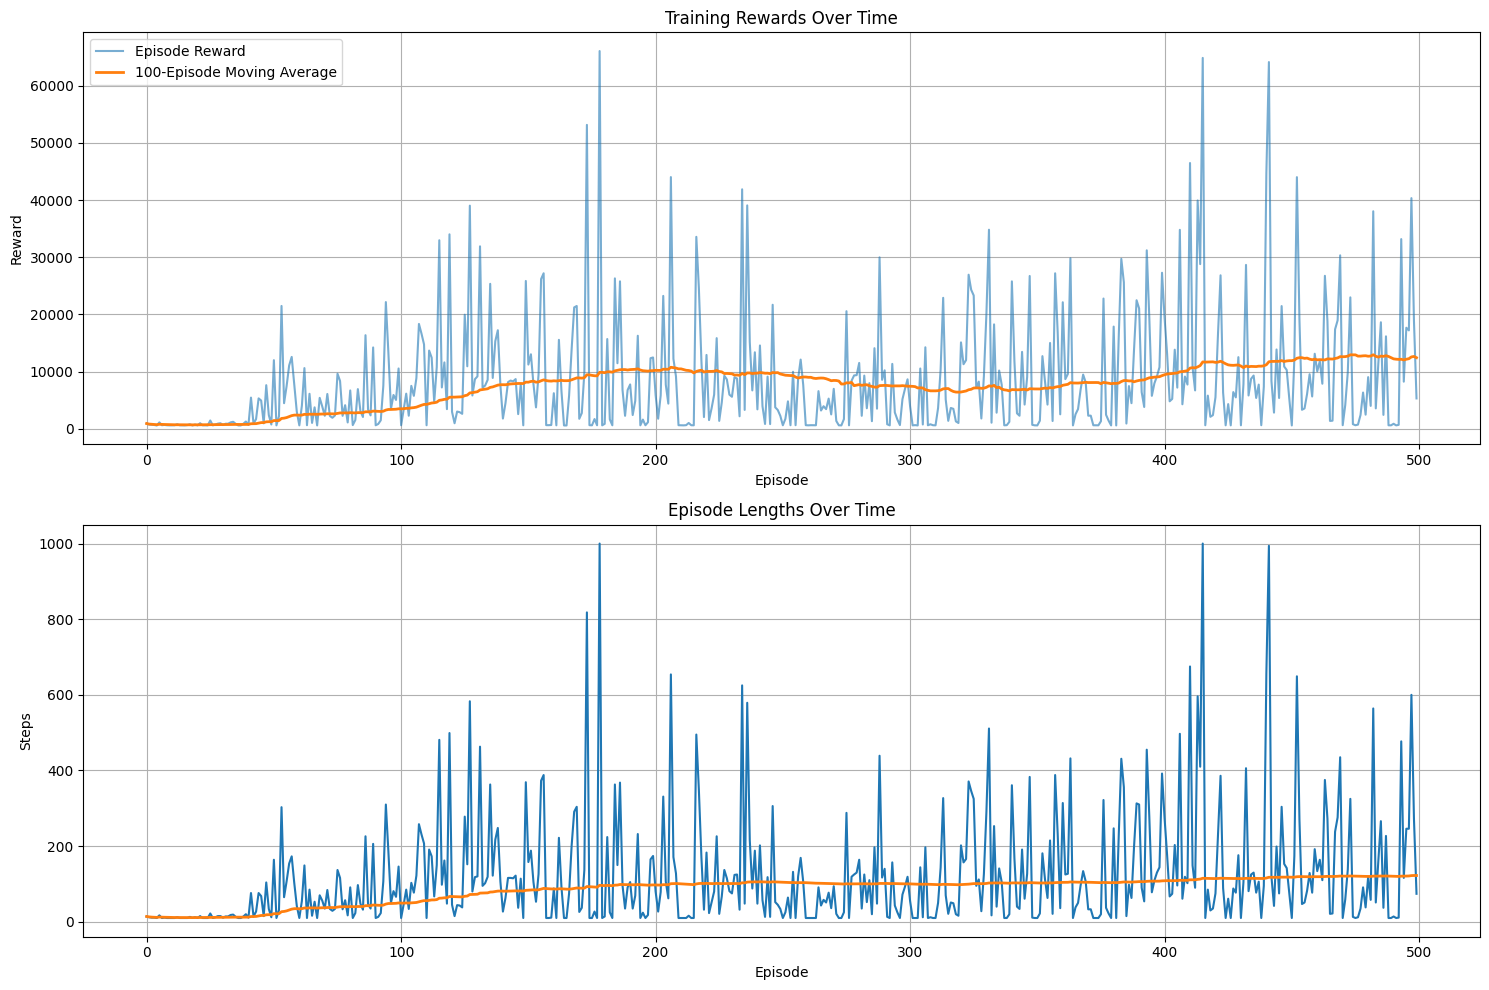

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(metrics_2['rewards'], label='Episode Reward', alpha=0.6)
plt.plot(metrics_2['moving_averages'], label=f'{100}-Episode Moving Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(metrics_2['episode_lengths'])
plt.plot(metrics_2['episode_lengths_average'], label=f'{100}-Episode Length Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Episode Lengths Over Time')
plt.grid(True)

plt.tight_layout()

In [11]:
agent_2.save("dqn_model_v2.pth")
plt.savefig('dqn_training_model_v2.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
#*********************************************************************************************
#DQN Improvement V3: DuelingDQN
#*********************************************************************************************

In [12]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(int(state_size), 256),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, int(action_size))
        )

    def forward(self, state):
        features = self.feature_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([exp.state for exp in experiences])
        actions = torch.LongTensor([exp.action for exp in experiences])
        rewards = torch.FloatTensor([exp.reward for exp in experiences])
        next_states = torch.FloatTensor([exp.next_state for exp in experiences])
        dones = torch.FloatTensor([exp.done for exp in experiences])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent(BaseAgent):
    def __init__(self, env, memory_size=100000, batch_size=64, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.999,
                 learning_rate=1e-4, target_update_frequency=500):
        super(DQNAgent, self).__init__(env.action_space)
        
        self.env = env
        obs = env.reset()
        self.state_size = len(obs.to_vect())
        self.action_space = env.action_space
        self.all_actions = [env.action_space({})]  
        
        for line_id in range(env.action_space.n_line):
            self.all_actions.append(env.action_space.disconnect_powerline(line_id=line_id))
            
            for bus_or in [1, 2]:
                for bus_ex in [1, 2]:
                    try:
                        reconnect_action = env.action_space.reconnect_powerline(
                            line_id=line_id,
                            bus_or=bus_or,
                            bus_ex=bus_ex
                        )
                        self.all_actions.append(reconnect_action)
                    except grid2op.Exceptions.Grid2OpException:
                        continue
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_frequency = target_update_frequency
        
        self.policy_net = DuelingDQN(self.state_size, len(self.all_actions))
        self.target_net = DuelingDQN(self.state_size, len(self.all_actions))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.memory = ReplayBuffer(memory_size)
        
        self.writer = SummaryWriter('runs/dqn_training')
        self.total_steps = 0
        
        print(f"State size: {self.state_size}")
        print(f"Number of actions: {len(self.all_actions)}")
    
    def act(self, observation, reward=0.0, done=False):
        state = self.convert_obs(observation)
        
        if random.random() < self.epsilon:
            action_idx = random.randrange(len(self.all_actions))
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                action_idx = q_values.argmax().item()
        
        return self.all_actions[action_idx]
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            best_actions = self.policy_net(next_states).argmax(1)
            next_q_values = self.target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.writer.add_scalar('Loss/train', loss.item(), self.total_steps)
        if self.total_steps % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def convert_obs(self, observation):
        return observation.to_vect()
    
    def convert_action(self, action):
        for idx, a in enumerate(self.all_actions):
            if a == action:
                return idx
        return 0  
    
    def save(self, path):
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

In [13]:
def analyze_training_rewards(env_name="l2rpn_case14_sandbox", n_episodes=1000, max_steps=1000, window_size=100):
    all_rewards_v3 = []
    episode_lengths_3 = []
    moving_averages_3 = []
    episode_lengths_average_3 = []
    best_reward_3 = float('-inf')
    worst_reward_3 = float('inf')
    reward_window_3 = deque(maxlen=window_size)
    env = grid2op.make(env_name)
    agent_3 = DQNAgent(env)
    
    print("Starting training...\n")
    
    for episode in range(n_episodes):
        observation = env.reset()
        episode_reward = 0
        steps = 0
        
        for step in range(max_steps):
            try:
                action = agent_3.act(observation)
                next_observation, reward, done, info = env.step(action)
                
                state = agent_3.convert_obs(observation)
                next_state = agent_3.convert_obs(next_observation)
                action_idx = agent_3.convert_action(action)
                agent_3.memory.push(state, action_idx, reward, next_state, done)
                
                episode_reward += reward
                steps += 1
                
                observation = next_observation
                agent_3.total_steps += 1
                agent_3.learn()
                
                if done:
                    break
                    
            except Exception as e:
                print(f"Error during episode {episode + 1}, step {step + 1}: {e}")
                break
        
        all_rewards_v3.append(episode_reward)
        episode_lengths_3.append(steps)
        reward_window_3.append(episode_reward)
        moving_averages_3.append(np.mean(list(reward_window_3)))
        episode_lengths_average_3.append(np.mean(list(episode_lengths_3)))
        best_reward_3 = max(best_reward_3, episode_reward)
        worst_reward_3 = min(worst_reward_3, episode_reward)
        
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(list(reward_window_3))
            print(f"Episode {episode + 1}/{n_episodes}")
            print(f"Recent Average Reward: {avg_reward:.2f}")
            print(f"Episode Reward: {episode_reward:.2f}")
            print(f"Steps: {steps}")
            print("-" * 50)
    
    print("\nTraining Summary:")
    print("-" * 50)
    print(f"Total Episodes: {n_episodes}")
    print(f"Best Reward: {best_reward_3:.2f}")
    print(f"Worst Reward: {worst_reward_3:.2f}")
    print(f"Average Reward: {np.mean(all_rewards_v3):.2f}")
    print(f"Median Reward: {np.median(all_rewards_v3):.2f}")
    print(f"Final {window_size}-Episode Average: {moving_averages_3[-1]:.2f}")
    print(f"Average Episode Length: {np.mean(episode_lengths_3):.2f} steps")
    print("-" * 50)
    
    return agent_3, {
        'rewards': all_rewards_v3,
        'moving_averages': moving_averages_3,
        'episode_lengths': episode_lengths_3,
        'episode_lengths_average': episode_lengths_average_3,
        'best_reward': best_reward_3,
        'worst_reward': worst_reward_3
    }

In [14]:
if __name__ == "__main__":
    agent_3, metrics_3 = analyze_training_rewards(n_episodes=500)

State size: 467
Number of actions: 101
Starting training...

Episode 10/500
Recent Average Reward: 152.21
Episode Reward: 185.82
Steps: 14
--------------------------------------------------
Episode 20/500
Recent Average Reward: 145.63
Episode Reward: 182.29
Steps: 5
--------------------------------------------------
Episode 30/500
Recent Average Reward: 156.47
Episode Reward: 55.29
Steps: 5
--------------------------------------------------
Episode 40/500
Recent Average Reward: 167.99
Episode Reward: 311.35
Steps: 13
--------------------------------------------------
Episode 50/500
Recent Average Reward: 169.14
Episode Reward: 187.23
Steps: 6
--------------------------------------------------
Episode 60/500
Recent Average Reward: 217.30
Episode Reward: 950.32
Steps: 20
--------------------------------------------------
Episode 70/500
Recent Average Reward: 273.43
Episode Reward: 1076.57
Steps: 28
--------------------------------------------------
Episode 80/500
Recent Average Reward: 3

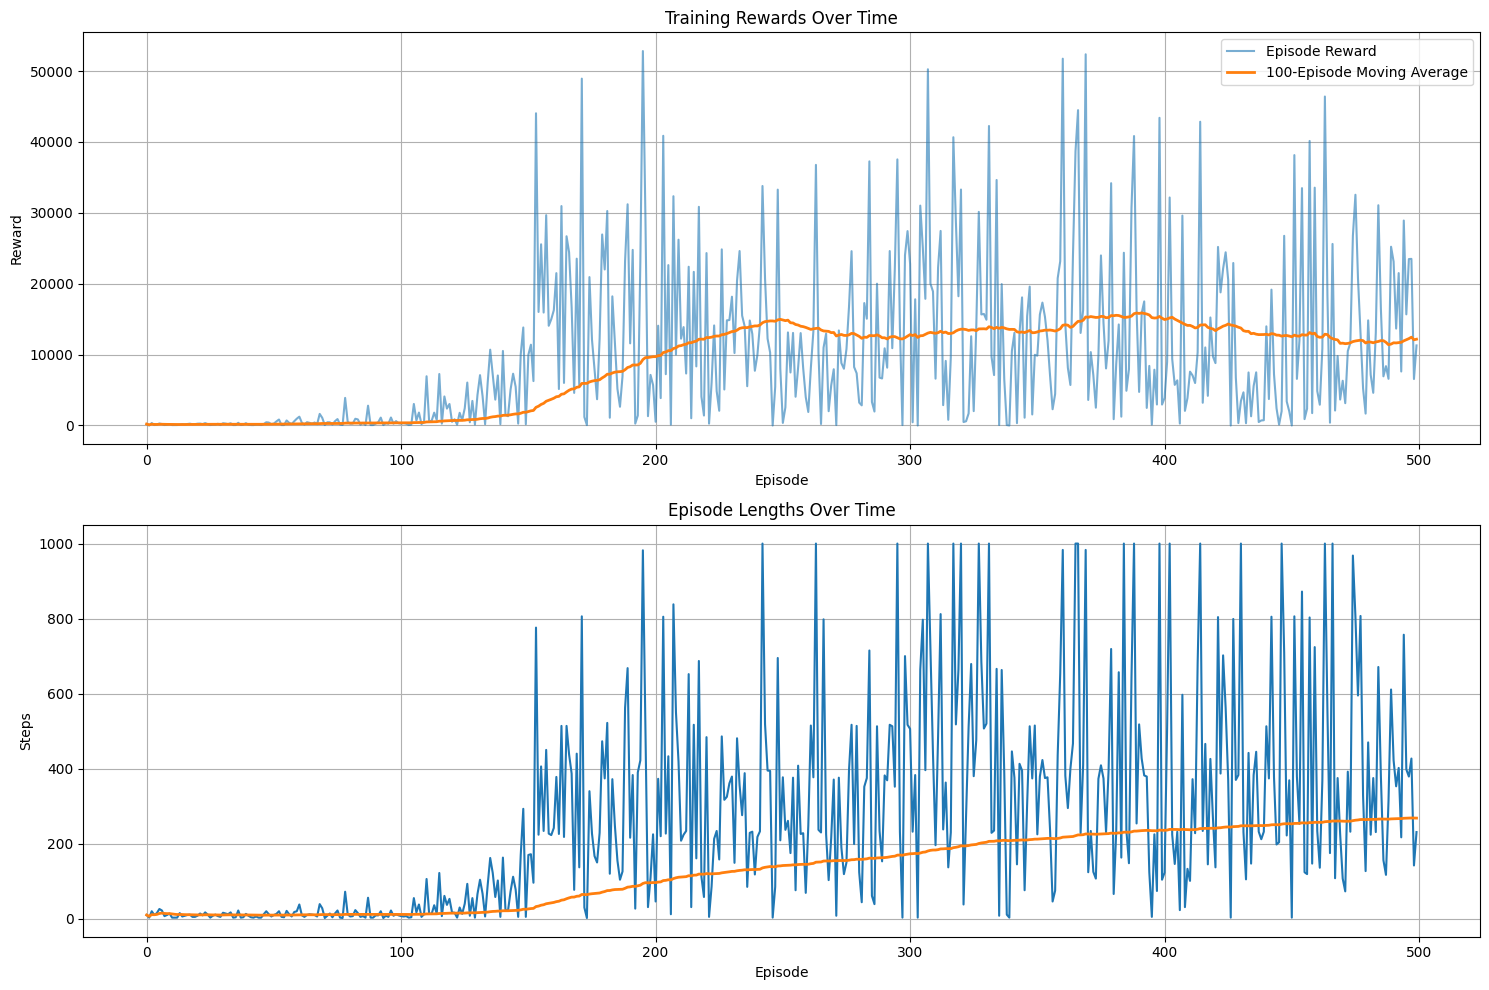

In [15]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(metrics_3['rewards'], label='Episode Reward', alpha=0.6)
plt.plot(metrics_3['moving_averages'], label=f'{100}-Episode Moving Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(metrics_3['episode_lengths'])
plt.plot(metrics_3['episode_lengths_average'], label=f'{100}-Episode Length Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Episode Lengths Over Time')
plt.grid(True)

plt.tight_layout()

In [16]:
agent_3.save("dqn_model_v3.pth")
plt.savefig('dqn_training_model_v3.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
#********************************************************
#DQN Model V4: DuelingDQN + Reward Shaping
#**********************************************************

In [17]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(int(state_size), 256),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, int(action_size))
        )

    def forward(self, state):
        features = self.feature_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([exp.state for exp in experiences])
        actions = torch.LongTensor([exp.action for exp in experiences])
        rewards = torch.FloatTensor([exp.reward for exp in experiences])
        next_states = torch.FloatTensor([exp.next_state for exp in experiences])
        dones = torch.FloatTensor([exp.done for exp in experiences])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent(BaseAgent):
    def __init__(self, env, memory_size=100000, batch_size=64, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.999,
                 learning_rate=1e-4, target_update_frequency=500):
        super(DQNAgent, self).__init__(env.action_space)
        
        self.env = env
        obs = env.reset()
        self.state_size = len(obs.to_vect())
        self.action_space = env.action_space
        self.all_actions = [env.action_space({})]  
        
        for line_id in range(env.action_space.n_line):
            self.all_actions.append(env.action_space.disconnect_powerline(line_id=line_id))
            
            for bus_or in [1, 2]:
                for bus_ex in [1, 2]:
                    try:
                        reconnect_action = env.action_space.reconnect_powerline(
                            line_id=line_id,
                            bus_or=bus_or,
                            bus_ex=bus_ex
                        )
                        self.all_actions.append(reconnect_action)
                    except grid2op.Exceptions.Grid2OpException:
                        continue
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_frequency = target_update_frequency
        
        self.policy_net = DuelingDQN(self.state_size, len(self.all_actions))
        self.target_net = DuelingDQN(self.state_size, len(self.all_actions))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.memory = ReplayBuffer(memory_size)
        
        self.writer = SummaryWriter('runs/dqn_training')
        self.total_steps = 0
        
        print(f"State size: {self.state_size}")
        print(f"Number of actions: {len(self.all_actions)}")
    
    def act(self, observation, reward=0.0, done=False):
        state = self.convert_obs(observation)
        
        if random.random() < self.epsilon:
            action_idx = random.randrange(len(self.all_actions))
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                action_idx = q_values.argmax().item()
        
        return self.all_actions[action_idx]
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            best_actions = self.policy_net(next_states).argmax(1)
            next_q_values = self.target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.writer.add_scalar('Loss/train', loss.item(), self.total_steps)
        if self.total_steps % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def convert_obs(self, observation):
        return observation.to_vect()
    
    def convert_action(self, action):
        for idx, a in enumerate(self.all_actions):
            if a == action:
                return idx
        return 0  
    
    def save(self, path):
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

In [18]:
def analyze_training_rewards(env_name="l2rpn_case14_sandbox", n_episodes=1000, max_steps=1000, window_size=100):
    all_rewards = []
    episode_lengths = []
    moving_averages = []
    episode_lengths_average = []
    best_reward = float('-inf')
    worst_reward = float('inf')
    reward_window = deque(maxlen=window_size)
    
    from grid2op.Parameters import Parameters
    params = Parameters()
    
    params.NO_OVERFLOW_DISCONNECTION = True
    params.MAX_LINE_STATUS_CHANGED = 999999
    params.MAX_SUB_CHANGED = 999999
    params.NB_TIMESTEP_OVERFLOW_ALLOWED = 5
    params.NB_TIMESTEP_RECONNECTION = 12
    
    env = grid2op.make(env_name, param=params)
    
    class SafetyWrapper:
        def __init__(self, env):
            self.env = env
            self.observation_space = env.observation_space
            self.action_space = env.action_space
            self.current_step = 0
            self.last_safe_state = None
        
        def reset(self):
            self.current_step = 0
            obs = self.env.reset()
            self.last_safe_state = obs
            return obs
        
        def step(self, action):
            self.current_step += 1
            
            try:
                simulated_obs, simulated_reward, simulated_done, simulated_info = self.env.simulate(action)
                
                if simulated_done and self.current_step < 10:
                    action = self.env.action_space()
                    obs, reward, done, info = self.env.step(action)
                else:
                    obs, reward, done, info = self.env.step(action)
                
                reward += 1.0
                
                if done and self.current_step < 10:
                    reward -= 100.0
                
                if done and self.current_step >= 10:
                    reward += 50.0
                
                self.last_safe_state = obs
                return obs, reward, done, info
                
            except Exception as e:
                print(f"Action caused error: {e}. Using fallback action.")
                action = self.env.action_space()
                return self.env.step(action)
    
    env = SafetyWrapper(env)
    agent = DQNAgent(env)
    agent.epsilon = 1.0
    agent.epsilon_decay = 0.995
    agent.epsilon_min = 0.05
    
    print(f"State size: {env.observation_space.size()}")
    print(f"Number of actions: {env.action_space.n}")
    print("Starting training...\n")
    
    for episode in range(n_episodes):
        observation = env.reset()
        episode_reward = 0
        steps = 0
        
        for step in range(max_steps):
            try:
                action = agent.act(observation)
                next_observation, reward, done, info = env.step(action)
                
                state = agent.convert_obs(observation)
                next_state = agent.convert_obs(next_observation)
                action_idx = agent.convert_action(action)
                agent.memory.push(state, action_idx, reward, next_state, done)
                
                episode_reward += reward
                steps += 1
                
                observation = next_observation
                agent.total_steps += 1
                agent.learn()
                
                if done:
                    break
                    
            except Exception as e:
                print(f"Error during episode {episode + 1}, step {step + 1}: {e}")
                break
        
        all_rewards.append(episode_reward)
        episode_lengths.append(steps)
        reward_window.append(episode_reward)
        moving_averages.append(np.mean(list(reward_window)))
        episode_lengths_average.append(np.mean(list(episode_lengths)))
        best_reward = max(best_reward, episode_reward)
        worst_reward = min(worst_reward, episode_reward)
        
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(list(reward_window))
            print(f"Episode {episode + 1}/{n_episodes}")
            print(f"Recent Average Reward: {avg_reward:.2f}")
            print(f"Episode Reward: {episode_reward:.2f}")
            print(f"Steps: {steps}")
            print(f"Epsilon: {agent.epsilon:.3f}")
            print("-" * 50)
    
    print("\nTraining Summary:")
    print("-" * 50)
    print(f"Total Episodes: {n_episodes}")
    print(f"Best Reward: {best_reward:.2f}")
    print(f"Worst Reward: {worst_reward:.2f}")
    print(f"Average Reward: {np.mean(all_rewards):.2f}")
    print(f"Median Reward: {np.median(all_rewards):.2f}")
    print(f"Final {window_size}-Episode Average: {moving_averages[-1]:.2f}")
    print(f"Average Episode Length: {np.mean(episode_lengths):.2f} steps")
    print("-" * 50)
    
    return agent, {
        'rewards': all_rewards,
        'moving_averages': moving_averages,
        'episode_lengths': episode_lengths,
        'episode_lengths_average': episode_lengths_average,
        'best_reward': best_reward,
        'worst_reward': worst_reward
    }

In [19]:
if __name__ == "__main__":
    agent_4, metrics_4 = analyze_training_rewards(n_episodes=500)

State size: 467
Number of actions: 101
State size: 467
Number of actions: 166
Starting training...

Episode 10/500
Recent Average Reward: 723.75
Episode Reward: 824.51
Steps: 13
Epsilon: 0.778
--------------------------------------------------
Episode 20/500
Recent Average Reward: 779.52
Episode Reward: 634.23
Steps: 10
Epsilon: 0.408
--------------------------------------------------
Episode 30/500
Recent Average Reward: 927.82
Episode Reward: 856.31
Steps: 13
Epsilon: 0.160
--------------------------------------------------
Episode 40/500
Recent Average Reward: 1893.65
Episode Reward: 5206.15
Steps: 75
Epsilon: 0.010
--------------------------------------------------
Episode 50/500
Recent Average Reward: 2352.47
Episode Reward: 643.61
Steps: 10
Epsilon: 0.010
--------------------------------------------------
Episode 60/500
Recent Average Reward: 3619.95
Episode Reward: 19489.76
Steps: 272
Epsilon: 0.010
--------------------------------------------------
Episode 70/500
Recent Average

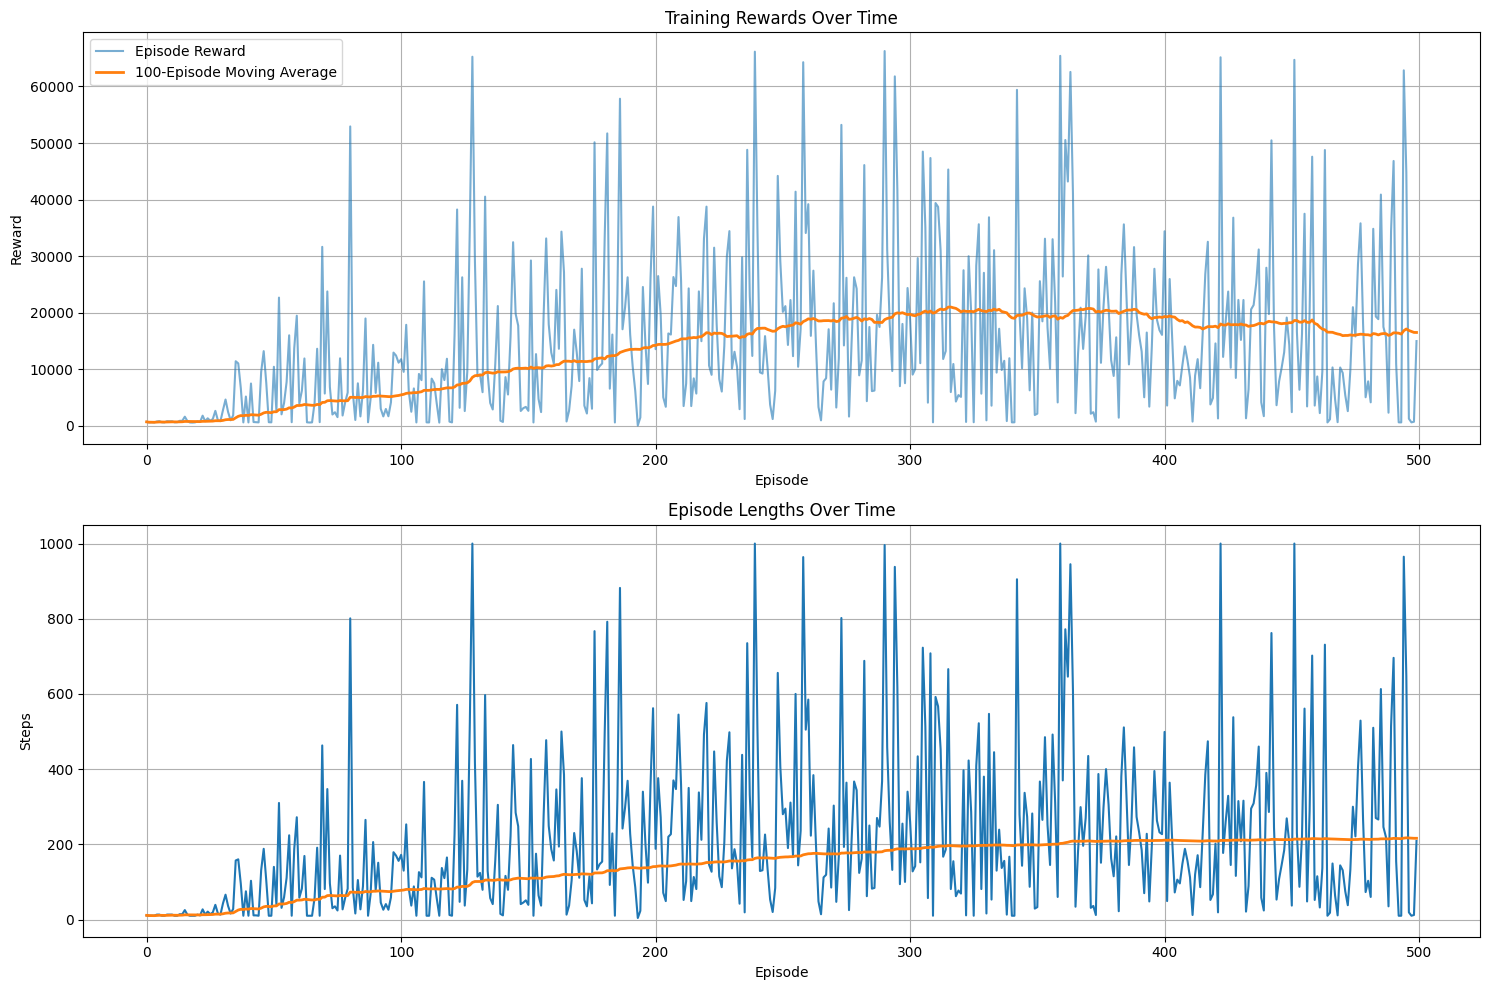

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(metrics_4['rewards'], label='Episode Reward', alpha=0.6)
plt.plot(metrics_4['moving_averages'], label=f'{100}-Episode Moving Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(metrics_4['episode_lengths'])
plt.plot(metrics_4['episode_lengths_average'], label=f'{100}-Episode Length Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Episode Lengths Over Time')
plt.grid(True)

plt.tight_layout()

In [21]:
agent_4.save("dqn_model_v4.pth")
plt.savefig('dqn_training_model_v4.png')

<Figure size 640x480 with 0 Axes>

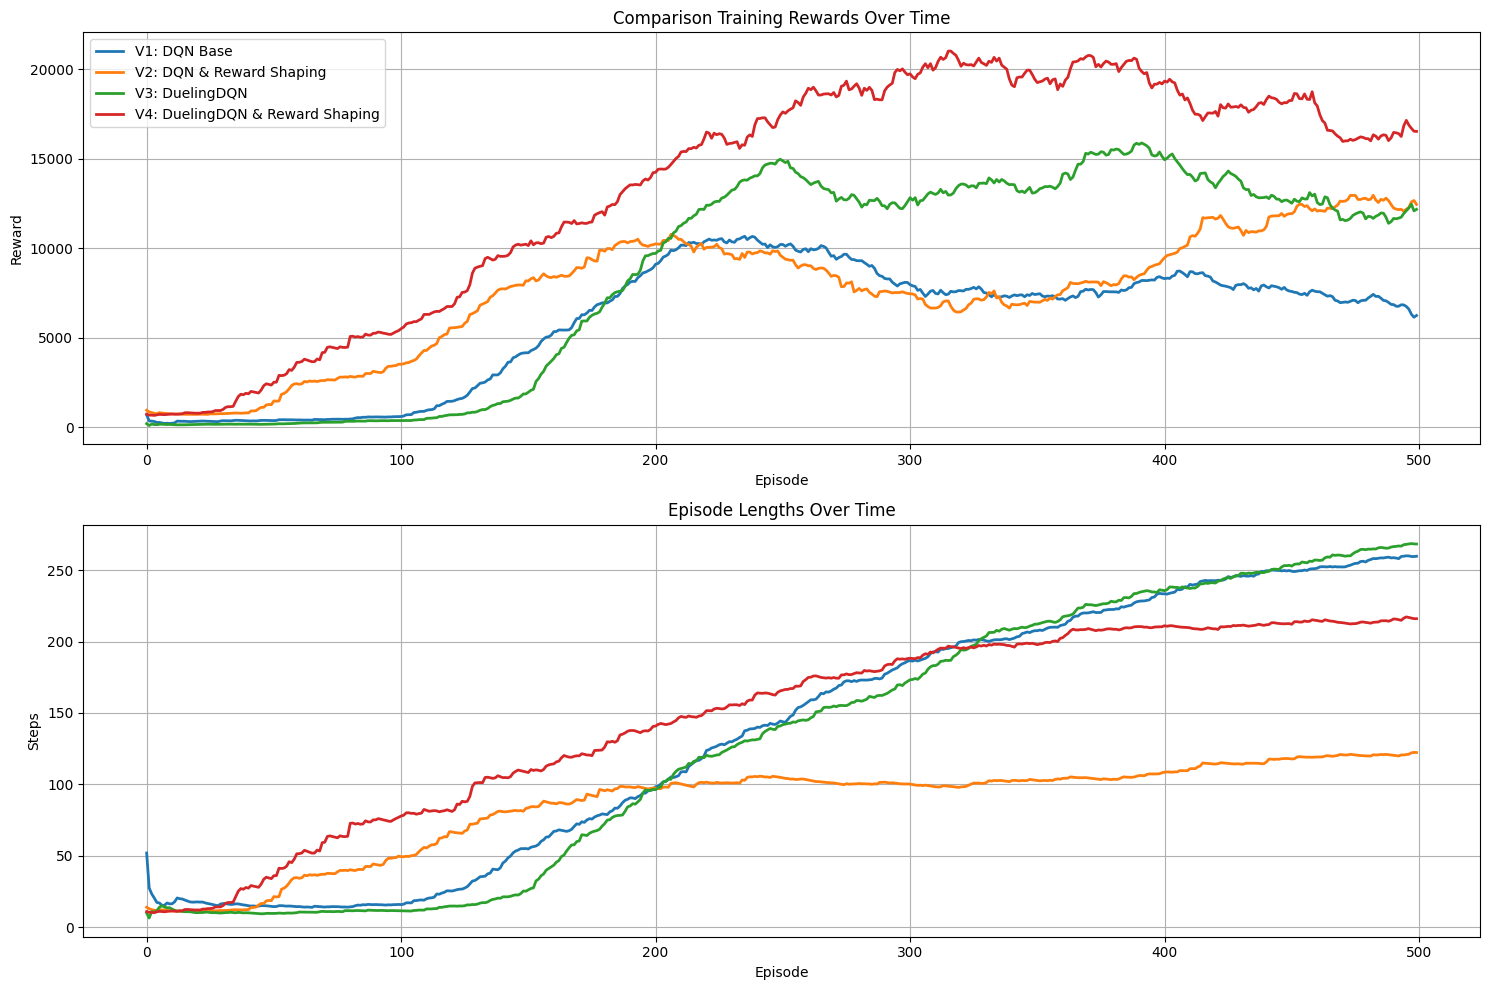

In [23]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(metrics['moving_averages'], label=f'V1: DQN Base', linewidth=2)
plt.plot(metrics_2['moving_averages'], label=f'V2: DQN & Reward Shaping', linewidth=2)
plt.plot(metrics_3['moving_averages'], label=f'V3: DuelingDQN', linewidth=2)
plt.plot(metrics_4['moving_averages'], label=f'V4: DuelingDQN & Reward Shaping', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Comparison Training Rewards Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(metrics['episode_lengths_average'], label=f'V1: DQN Base', linewidth=2)
plt.plot(metrics_2['episode_lengths_average'], label=f'V2: DQN & Reward Shaping', linewidth=2)
plt.plot(metrics_3['episode_lengths_average'], label=f'V3: DuelingDQN', linewidth=2)
plt.plot(metrics_4['episode_lengths_average'], label=f'V4: DuelingDQN & Reward Shaping', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Episode Lengths Over Time')
plt.grid(True)

plt.tight_layout()
plt.savefig('dqn_training_model_comparison.png')